## Assignment 2, Natural Language Processing, Group 14

# Pre-processing

## Filter corpus

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
import re
import random
random.seed(45)

# Load and filter the data
news_df = pd.read_csv('us_equities_news_dataset.csv')
news_df = news_df.drop(columns=['article_id', 'url', 'category', 'release_date', 'provider'])
news_df = news_df.dropna(subset=['content'])
news_df['content'] = news_df['content'].astype(str)


# Filter for articles mentioning 'Nvidia' or 'NVDA' in the ticker, title, or content
pattern_nvidia = r'\b(?:Nvidia|NVDA)\b'
nvidia_mentioned_articles = news_df[
    (news_df['ticker'] == 'NVDA') | 
    news_df['title'].str.contains(pattern_nvidia, case=False, na=False) |
    news_df['content'].str.contains(pattern_nvidia, case=False, na=False)
]

# Save and reload filtered articles to avoid duplicate content
filtered_corpus = nvidia_mentioned_articles.copy()
filtered_corpus.to_csv('filtered_corpus.csv', index=False)

print('Filtered corpus dimensions:', filtered_corpus.shape)

Filtered corpus dimensions: (3459, 4)


## Clean and tokenize filtered corpus

In [2]:
news_df = pd.read_csv('filtered_corpus.csv')

# Set up stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess and tokenize text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove leading and trailing whitespace
    text = text.strip()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove 1-letter words and stopwords
    tokens = [token for token in tokens if len(token) > 1 and token not in stop_words]
    return tokens

# Apply the function to the content column and create a new 'tokens' column
news_df['tokens'] = news_df['content'].apply(preprocess_text)

# Remove duplicates based on the 'tokens' column
df = news_df.drop_duplicates(subset=['tokens'])
print('Filtered corpus dimensions:', df.shape)
print(df[['content', 'tokens']].head(10))


Filtered corpus dimensions: (3306, 5)
                                             content  \
0  ECB Effects\nThe move in the euro was huge  fa...   
1  6 Stocks To Watch  March 6 Trading Session\nSt...   
2  Investing com   A rout in Apple and Facebook  ...   
3  For Immediate ReleaseChicago  IL   January 13 ...   
4  With 4 500 companies bringing their innovation...   
5  With 4 500 companies bringing their innovation...   
6  When trading opened in 2019  investors were ju...   
7  Excitement is building up for the 2020 Summer ...   
8  For Immediate ReleaseChicago  IL   December 3 ...   
9  For Immediate ReleaseChicago  IL   November 26...   

                                              tokens  
0  [ecb, effects, move, euro, huge, falling, pips...  
1  [stocks, watch, march, trading, session, stock...  
2  [investing, com, rout, apple, facebook, nasdaq...  
3  [immediate, releasechicago, il, january, zacks...  
4  [companies, bringing, innovations, ces, jan, g...  
5  [companies, 

In [3]:
# Function to convert the tokenized column to a list of lists (flatten list)
def make_list_of_lists(data_frame, column_name):
    data = data_frame[column_name].tolist()
    return data

# Create the list of lists for modeling
data = make_list_of_lists(df, 'tokens')
print('Number of documents in the list of lists:', len(data))

Number of documents in the list of lists: 3306


## top-n% bottom-n% removal

In [4]:
from collections import Counter

def remove_n_percent(processed_text, n=0):
    if n > 0:
        # Flatten the list of lists to count word frequencies
        word_freq = Counter([word for doc in processed_text for word in doc])
        # Get the top n% most frequent words
        top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
        # Get the bottom n% least frequent words
        bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
        # Filter the data to remove these words
        processed_text = [[word for word in doc if word not in top_n and word not in bottom_n] for doc in processed_text]
        processed_text = [doc for doc in processed_text if len(doc) > 0]
    return processed_text

# Train FLSA-W Model

In [5]:
from FuzzyTM import FLSA_W

# Parameters
flsaw_data = data
num_topics = 20
num_words = 10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.007*"roundup" + 0.0064*"episode" + 0.0058*"discussing" + 0.0058*"afford" + 0.0053*"unpredictable" + 0.0052*"thomas" + 0.0052*"elon" + 0.005*"knowing" + 0.005*"daniel" + 0.0049*"entrepreneurs"'), (1, '0.0135*"art" + 0.0131*"theory" + 0.0101*"communities" + 0.0096*"preserve" + 0.0093*"grand" + 0.0093*"podcast" + 0.0092*"thoughts" + 0.0091*"written" + 0.009*"minds" + 0.0081*"human"'), (2, '0.0234*"richard" + 0.0214*"books" + 0.0214*"book" + 0.0211*"professor" + 0.0185*"certainty" + 0.0181*"science" + 0.0173*"unstoppable" + 0.0163*"modern" + 0.0158*"conscious" + 0.014*"woke"'), (3, '0.0039*"therapeutics" + 0.0025*"ralph" + 0.0024*"writer" + 0.0024*"racing" + 0.0023*"dutch" + 0.0021*"marathon" + 0.002*"genetics" + 0.0019*"transmission" + 0.0018*"diamond" + 0.0018*"fever"'), (4, '0.0042*"broader" + 0.0041*"led" + 0.0038*"rise" + 0.0037*"profit" + 0.0036*"systems" + 0.0036*"energy" + 0.0036*"intc" + 0.0035*"meanwhile" + 0.0035*"thursday" + 0.0035*"added"'), (5, '0.0005*"reiterates" + 

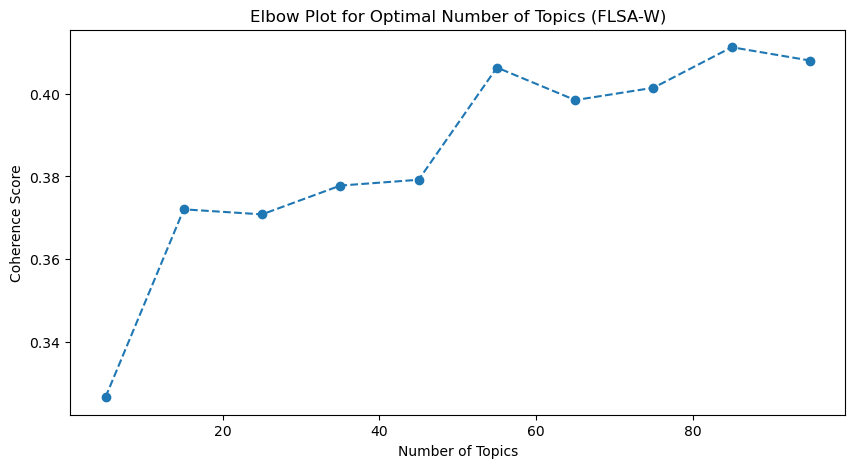

In [6]:
import matplotlib.pyplot as plt
# Range of topic numbers to test
flsaw_data = data
topic_numbers = range(5, 101, 10)
coherence_scores = []

for num_topics in topic_numbers:
    flsaW = FLSA_W(
        input_file=flsaw_data,  # Preprocessed data
        num_topics=num_topics,
        num_words=10
    )
    pwgt, ptgd = flsaW.get_matrices()  # Train the model
    coherence_score = flsaW.get_coherence_score()  # Calculate coherence
    coherence_scores.append(coherence_score)

# Plotting the Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(topic_numbers, coherence_scores, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Plot for Optimal Number of Topics (FLSA-W)')
plt.show()

After 60 topics it the curve starts to flatten. There is no substantial increase in the coherence score. We can experiment with 60 topics.

# Experimentation

# Iteration 0: Elbow point = 60 topics

In [7]:
# Parameters
flsaw_data = data
num_topics = 60
num_words = 10 

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0007*"bmwyy" + 0.0007*"soxs" + 0.0005*"wsm" + 0.0005*"kopn" + 0.0005*"kopin" + 0.0005*"ipxl" + 0.0005*"topsline" + 0.0005*"mpwr" + 0.0005*"labu" + 0.0005*"loxo"'), (1, '0.0293*"nvidia" + 0.027*"nyse" + 0.0261*"hold" + 0.0255*"price" + 0.0224*"past" + 0.0217*"recently" + 0.0209*"sell" + 0.0198*"term" + 0.0184*"shares" + 0.0183*"likely"'), (2, '0.0055*"blind" + 0.0051*"touches" + 0.0045*"jay" + 0.0044*"referring" + 0.004*"empirical" + 0.0036*"enriched" + 0.0035*"crops" + 0.0034*"beautiful" + 0.0033*"intuition" + 0.0029*"livestream"'), (3, '0.0074*"breakthrough" + 0.0068*"falling" + 0.0065*"session" + 0.0065*"jones" + 0.0059*"volume" + 0.0059*"july" + 0.0057*"measures" + 0.0056*"declining" + 0.0055*"helping" + 0.0054*"select"'), (4, '0.0065*"lrcx" + 0.006*"skyrocketing" + 0.0059*"fund" + 0.0057*"info" + 0.0056*"ignited" + 0.0056*"frame" + 0.0054*"editor" + 0.005*"pulled" + 0.005*"automation" + 0.005*"cnbc"'), (5, '0.0012*"distinct" + 0.0012*"polaris" + 0.0012*"proclaimed" + 0.0011

Diversity score is almost 1.0 indicates that the topics are completely distinct from each other, with no significant overlap in the words that define them. 

Coherence score of 0.40 suggests that while the topics have some level of meaningful structure, there is room for improvement.

Overall, iteration reveals a promising range of financial and market-related topics but also includes abstract and niche terms that may require additional filtering or reassessment of the topic modeling parameters to enhance the coherence and interpretability.
For example, Topic 44 is particularly relevant for the semiconductor industry, containing terms like “chip,” “investments,” and “rising,” which relate to market trends in chip production and tech investments.
On the other hand, Topic 0 contains company codes or niche financial terms like “bmwyy,” “soxs,” and “otcpk,” which may be outlier content within the dataset.

# Iteration 1: Remove top 5% and bottom 5%

In [8]:
# Parameters
flsaw_data = remove_n_percent(data, 5)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.02*"nine" + 0.0139*"telling" + 0.0108*"sitting" + 0.0107*"enjoy" + 0.0105*"operator" + 0.0105*"practices" + 0.0104*"ben" + 0.0101*"patient" + 0.0095*"load" + 0.0093*"mover"'), (1, '0.0207*"compelling" + 0.018*"calling" + 0.0129*"linked" + 0.0128*"race" + 0.0118*"secret" + 0.0117*"crazy" + 0.0112*"tackle" + 0.0108*"crack" + 0.0099*"coronavirus" + 0.0086*"killed"'), (2, '0.0207*"surrounding" + 0.0196*"trouble" + 0.0191*"tap" + 0.0161*"felt" + 0.014*"jensen" + 0.0122*"musk" + 0.0117*"shown" + 0.0117*"shifted" + 0.0113*"scientific" + 0.0097*"filled"'), (3, '0.0053*"evp" + 0.0043*"industrials" + 0.0042*"sluggish" + 0.0039*"peers" + 0.0037*"walt" + 0.0036*"partial" + 0.0035*"execution" + 0.0035*"reiterated" + 0.0034*"drove" + 0.0034*"barrels"'), (4, '0.0059*"announces" + 0.0055*"supplies" + 0.0051*"downward" + 0.0048*"representing" + 0.0047*"sustained" + 0.0046*"parent" + 0.0045*"automakers" + 0.0045*"reflected" + 0.0043*"bounced" + 0.0043*"capable"'), (5, '0.0034*"avoided" + 0.0026*

Coherence score dropped significantly while diversity seems stable.

## Iteration 2: top 10% and bottom 10%

In [9]:
# Parameters
flsaw_data = remove_n_percent(data, 10)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0058*"collaborated" + 0.0056*"proving" + 0.0056*"imperative" + 0.0046*"productive" + 0.0046*"madness" + 0.0044*"lunch" + 0.0037*"watson" + 0.0037*"sake" + 0.0034*"crises" + 0.0033*"legitimacy"'), (1, '0.0054*"fold" + 0.005*"fomc" + 0.0046*"theresa" + 0.0043*"replacing" + 0.0042*"blockbuster" + 0.0041*"returning" + 0.004*"sipc" + 0.0039*"briefing" + 0.0039*"passenger" + 0.0039*"penetration"'), (2, '0.0239*"realm" + 0.0233*"confusion" + 0.0229*"southwest" + 0.0215*"pronounced" + 0.0206*"loved" + 0.0197*"physics" + 0.0195*"practical" + 0.0195*"todd" + 0.0183*"chromebook" + 0.0175*"bag"'), (3, '0.0077*"sooner" + 0.0074*"viewed" + 0.0066*"barclays" + 0.0064*"households" + 0.0064*"seasonality" + 0.0053*"buttons" + 0.0052*"translation" + 0.0048*"matt" + 0.0048*"toronto" + 0.0047*"incorporate"'), (4, '0.0206*"judge" + 0.0157*"ruling" + 0.0143*"comply" + 0.0142*"posts" + 0.0134*"glance" + 0.0131*"sites" + 0.0129*"shelves" + 0.0077*"diversity" + 0.0074*"suggestions" + 0.006*"ship"'), (5,

A significant increase in Coherence and Diversity score after the previous iteration but still lower than Iteration 0.

There are some typos like 'combinationhere' and 'saysaccording'. We can remove move words to avoid the typos.

## Iteration 3: top 15% and bottom 15%

In [10]:
# Parameters
flsaw_data = remove_n_percent(data, 15)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.006*"confirming" + 0.0057*"checking" + 0.0049*"ihs" + 0.0046*"pundits" + 0.0045*"litigation" + 0.0044*"intervention" + 0.0042*"distribute" + 0.0041*"travelers" + 0.0041*"ed" + 0.0041*"efficiencies"'), (1, '0.0222*"diversity" + 0.0196*"behalf" + 0.0104*"feet" + 0.0085*"xm" + 0.0084*"mcmilon" + 0.0084*"juventus" + 0.0084*"atomics" + 0.0084*"censors" + 0.0084*"bhanga" + 0.0084*"millward"'), (2, '0.0672*"mit" + 0.0519*"candace" + 0.0418*"norepinephrine" + 0.0363*"subconscious" + 0.0311*"teller" + 0.0218*"hormones" + 0.0177*"pert" + 0.0137*"experiments" + 0.0124*"technologically" + 0.0106*"tribalism"'), (3, '0.046*"preserve" + 0.0398*"okay" + 0.0329*"jungle" + 0.0325*"deeply" + 0.0323*"downstream" + 0.0316*"priorities" + 0.0313*"communities" + 0.031*"treasure" + 0.0305*"brother" + 0.03*"quest"'), (4, '0.0192*"rader" + 0.0187*"respiratory" + 0.0185*"pandemic" + 0.0181*"vaccines" + 0.0167*"mortality" + 0.0167*"mers" + 0.0167*"influenza" + 0.0167*"maricopa" + 0.0167*"cov" + 0.0167*"cer

Coherence score of approximately 0.46 is an improvement from the starting point 0.40. This suggests that the topics generated in this iteration are more semantically meaningful, with words in each topic being more closely related.

## Iteration 4: top 20% and bottom 20%

In [19]:
# Parameters
flsaw_data = remove_n_percent(data, 20)
num_topics=60
num_words=10

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0079*"workload" + 0.0076*"disappear" + 0.0075*"admitted" + 0.0069*"reflection" + 0.0068*"scanning" + 0.0064*"secrets" + 0.0056*"column" + 0.0055*"chooses" + 0.0054*"granting" + 0.0051*"smartwatch"'), (1, '0.0296*"berkeley" + 0.0266*"keith" + 0.02*"modify" + 0.019*"addictive" + 0.0183*"therapies" + 0.0175*"discovering" + 0.0174*"cassandra" + 0.0172*"caliber" + 0.017*"feng" + 0.0168*"ponzi"'), (2, '0.5845*"animals" + 0.048*"species" + 0.016*"animal" + 0.0091*"intersection" + 0.0087*"ancient" + 0.0086*"mammals" + 0.0073*"joking" + 0.0068*"spacex" + 0.0064*"sums" + 0.006*"feelings"'), (3, '0.0204*"understood" + 0.0172*"complexities" + 0.0154*"suing" + 0.0123*"creatures" + 0.0104*"defect" + 0.0103*"receptor" + 0.01*"unrealistic" + 0.01*"hospital" + 0.0093*"weighty" + 0.0089*"bucks"'), (4, '0.0093*"addressing" + 0.0091*"men" + 0.0089*"totaling" + 0.0073*"harness" + 0.0064*"devaluation" + 0.0064*"visits" + 0.0061*"paths" + 0.0055*"sheets" + 0.005*"ng" + 0.0049*"defending"'), (5, '0.04

The increase in coherence indicates that the adjusting top_n_percent to 15% helped create more coherent topics and removed most typos but diversity decreased significantly. Relying solely on raw frequency, we may have removed important words from the corpus.



## Iteration 5: num_words per topic = 5

In [20]:
# Parameters
flsaw_data = remove_n_percent(data, 15)
num_topics=60
num_words=5

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.034*"anxiety" + 0.0297*"lee" + 0.0275*"responses" + 0.0234*"scan" + 0.0188*"dragon"'), (1, '0.0047*"council" + 0.0044*"ordering" + 0.0042*"cupertino" + 0.0042*"costly" + 0.004*"outlets"'), (2, '0.0077*"removal" + 0.0075*"incorporate" + 0.007*"stopping" + 0.0057*"clause" + 0.0056*"nationwide"'), (3, '0.0019*"blows" + 0.0018*"rocks" + 0.0018*"retaliated" + 0.0017*"raymond" + 0.0017*"functionalities"'), (4, '0.0057*"wfe" + 0.0053*"ironically" + 0.005*"bankers" + 0.005*"fits" + 0.0047*"lipacis"'), (5, '0.0192*"rader" + 0.0187*"respiratory" + 0.0185*"pandemic" + 0.0181*"vaccines" + 0.0167*"sanitation"'), (6, '0.0214*"diversity" + 0.0197*"behalf" + 0.0102*"feet" + 0.0086*"xm" + 0.008*"satoshi"'), (7, '0.0021*"dented" + 0.002*"badly" + 0.0019*"cites" + 0.0019*"feast" + 0.0019*"breakeven"'), (8, '0.0678*"commonly" + 0.0585*"province" + 0.0468*"compass" + 0.0466*"mild" + 0.0453*"probable"'), (9, '0.078*"spreading" + 0.0573*"hospitals" + 0.0568*"ill" + 0.0504*"nicholas" + 0.0469*"champio

Coherence score decreased when lowering number of words per topic.

Some topics are related to neurology and health themes. Majority of the words in the topics seem irrelevant.

## Iteration 6: num_words per topic = 15

In [21]:
# Parameters
flsaw_data = remove_n_percent(data, 15)
num_topics=60
num_words=15

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0049*"scaled" + 0.0046*"softening" + 0.0041*"disk" + 0.0039*"claiming" + 0.0039*"ssys" + 0.0033*"renowned" + 0.0032*"ample" + 0.0032*"obstacle" + 0.0031*"headway" + 0.003*"mo" + 0.003*"kraft" + 0.0029*"eyeing" + 0.0029*"reign" + 0.0028*"dining" + 0.0028*"understandably"'), (1, '0.0163*"accepted" + 0.0147*"undisclosed" + 0.0136*"disagree" + 0.0125*"english" + 0.0093*"thailand" + 0.0087*"genuine" + 0.0084*"contained" + 0.0082*"soccer" + 0.0082*"fighter" + 0.0081*"hopefully" + 0.0074*"unlawful" + 0.0073*"ming" + 0.0072*"philippines" + 0.0071*"flew" + 0.0071*"kuo"'), (2, '0.005*"cleaning" + 0.0047*"calculations" + 0.0039*"favorites" + 0.0036*"berlin" + 0.0036*"postponed" + 0.0035*"pipelines" + 0.0034*"rounding" + 0.0034*"brake" + 0.0033*"negotiator" + 0.0032*"convenient" + 0.0032*"challenged" + 0.0032*"allies" + 0.0031*"cry" + 0.003*"addressed" + 0.003*"protectionist"'), (3, '0.1871*"stars" + 0.1687*"exploring" + 0.1566*"birth" + 0.0481*"degrees" + 0.0193*"gem" + 0.0154*"explode" +

Coherence score slightly increased compared to 10 words per topic.

## Iteration 7: num_words per topic = 20

In [22]:
# Parameters
flsaw_data = remove_n_percent(data, 15)
num_topics=60
num_words=20

flsaW = FLSA_W(
    input_file = flsaw_data,
    num_topics=num_topics,
    num_words=num_words,
)

flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL


print(flsaW.show_topics())

for topic in flsaW.show_topics(representation='words'):
    print(topic)
  
    
print("Coherence Score:", flsaW.get_coherence_score())
print("Diversity Score:",flsaW.get_diversity_score())
print("Interpretability Score:",flsaW.get_interpretability_score())

[(0, '0.0207*"false" + 0.0177*"career" + 0.0175*"shock" + 0.0172*"hate" + 0.0171*"treat" + 0.0162*"danger" + 0.0158*"conversations" + 0.0143*"cooker" + 0.0141*"description" + 0.0127*"student" + 0.0114*"rationale" + 0.0106*"vocal" + 0.0101*"colleagues" + 0.0093*"demographics" + 0.0089*"wit" + 0.0088*"centre" + 0.0075*"eddy" + 0.0074*"allen" + 0.0073*"repeats" + 0.0069*"genes"'), (1, '0.0283*"explodes" + 0.0282*"circles" + 0.028*"amassing" + 0.0277*"nails" + 0.027*"harnessed" + 0.027*"happiness" + 0.0267*"grains" + 0.0267*"livestock" + 0.0261*"narrated" + 0.0254*"timetables" + 0.0249*"npr" + 0.0235*"derek" + 0.0224*"consequential" + 0.0221*"intersection" + 0.016*"interactions" + 0.0142*"vested" + 0.014*"mental" + 0.0122*"rituals" + 0.0105*"fascinated" + 0.0104*"orbit"'), (2, '0.0406*"originated" + 0.0391*"syndrome" + 0.0311*"varieties" + 0.0311*"infections" + 0.0311*"jane" + 0.031*"benoit" + 0.031*"mandelbrot" + 0.0309*"pseudo" + 0.0307*"champ" + 0.0306*"garry" + 0.0306*"kasparov" + 0.03

Increasing the number of words per topic above 15 improved coherence but reduced diversity score. Moreover, increasing the number of topics makes interpreting the themes more challenging for the human eye and lowers the interpretability score.

Removing the top and bottom 20% of the most frequent words seems to have improved coherence without significantly affecting diversity. This suggests that the common and rare words removed in this step were likely not contributing much to topic quality. However, by relying solely on raw frequency, we may have removed important words from the corpus. 

To address this, we can use a document frequency threshold as part of the TF-IDF calculation, removing words based on the proportion of documents they appear in rather than just their raw frequency. This approach takes into account how widely or narrowly distributed a word is across the corpus. 

Detecting bigrams and trigrams and applying TF-IDF-based filtering (using max_df and min_df) is can be a relatively safer approach. This method identifies word pairs and triplets that convey significant meaning, capturing important multi-word phrases like “stock market” or “price increase” that single-word analysis might overlook. Next, TF-IDF filtering adapts to the actual distribution of words across documents, effectively removing overly common or extremely rare terms based on their document frequency. This may provide a more targeted and context-aware way to clean data compared to the more arbitrary removal of a fixed top and bottom percentage, which risks excluding contextually important words or retaining irrelevant ones. Further experiments on FLSA-W model are presented in a separate jupyter notebook named "Experiments with FLSA-W".